Please upload your Excel file...


Saving N1.xlsx to N1 (4).xlsx

Processing: N1 (4).xlsx

FULL DATASET:
  Date range: 2023-08-15 to 2023-09-15
  Total days: 32
  Total readings: 14,317

ANALYSIS PERIOD:
  Food removed: 2023-09-05
  Skipping first 2 days after food removal
  Analysis starts: 2023-09-07
  Date range: 2023-09-07 to 2023-09-15
  Days analyzed: 9
  Removed first hour of each day: 108 readings (calibration period)
  Final readings: 2,343

TEMPERATURE STATISTICS:
  count   : 2343.00C
  mean    :  36.34C
  std     :   1.17C
  min     :  33.98C
  5%      :  34.68C
  10%     :  34.94C
  25%     :  35.36C
  50%     :  36.16C
  75%     :  37.41C
  90%     :  38.03C
  95%     :  38.20C
  max     :  38.65C

  Coldest 5% of readings: < 34.68C
  Coldest 10% of readings: < 34.94C
  Coldest 25% of readings: < 35.36C

TORPOR DETECTION:
  Threshold: 35.5C
  Minimum duration: 0.25 hours

  Readings below 35.5C: 761 (32.5%)
  Temperature drops below threshold: 74
  Valid torpor bouts found: 41

DAYS WITH TORPOR (9 days):

D

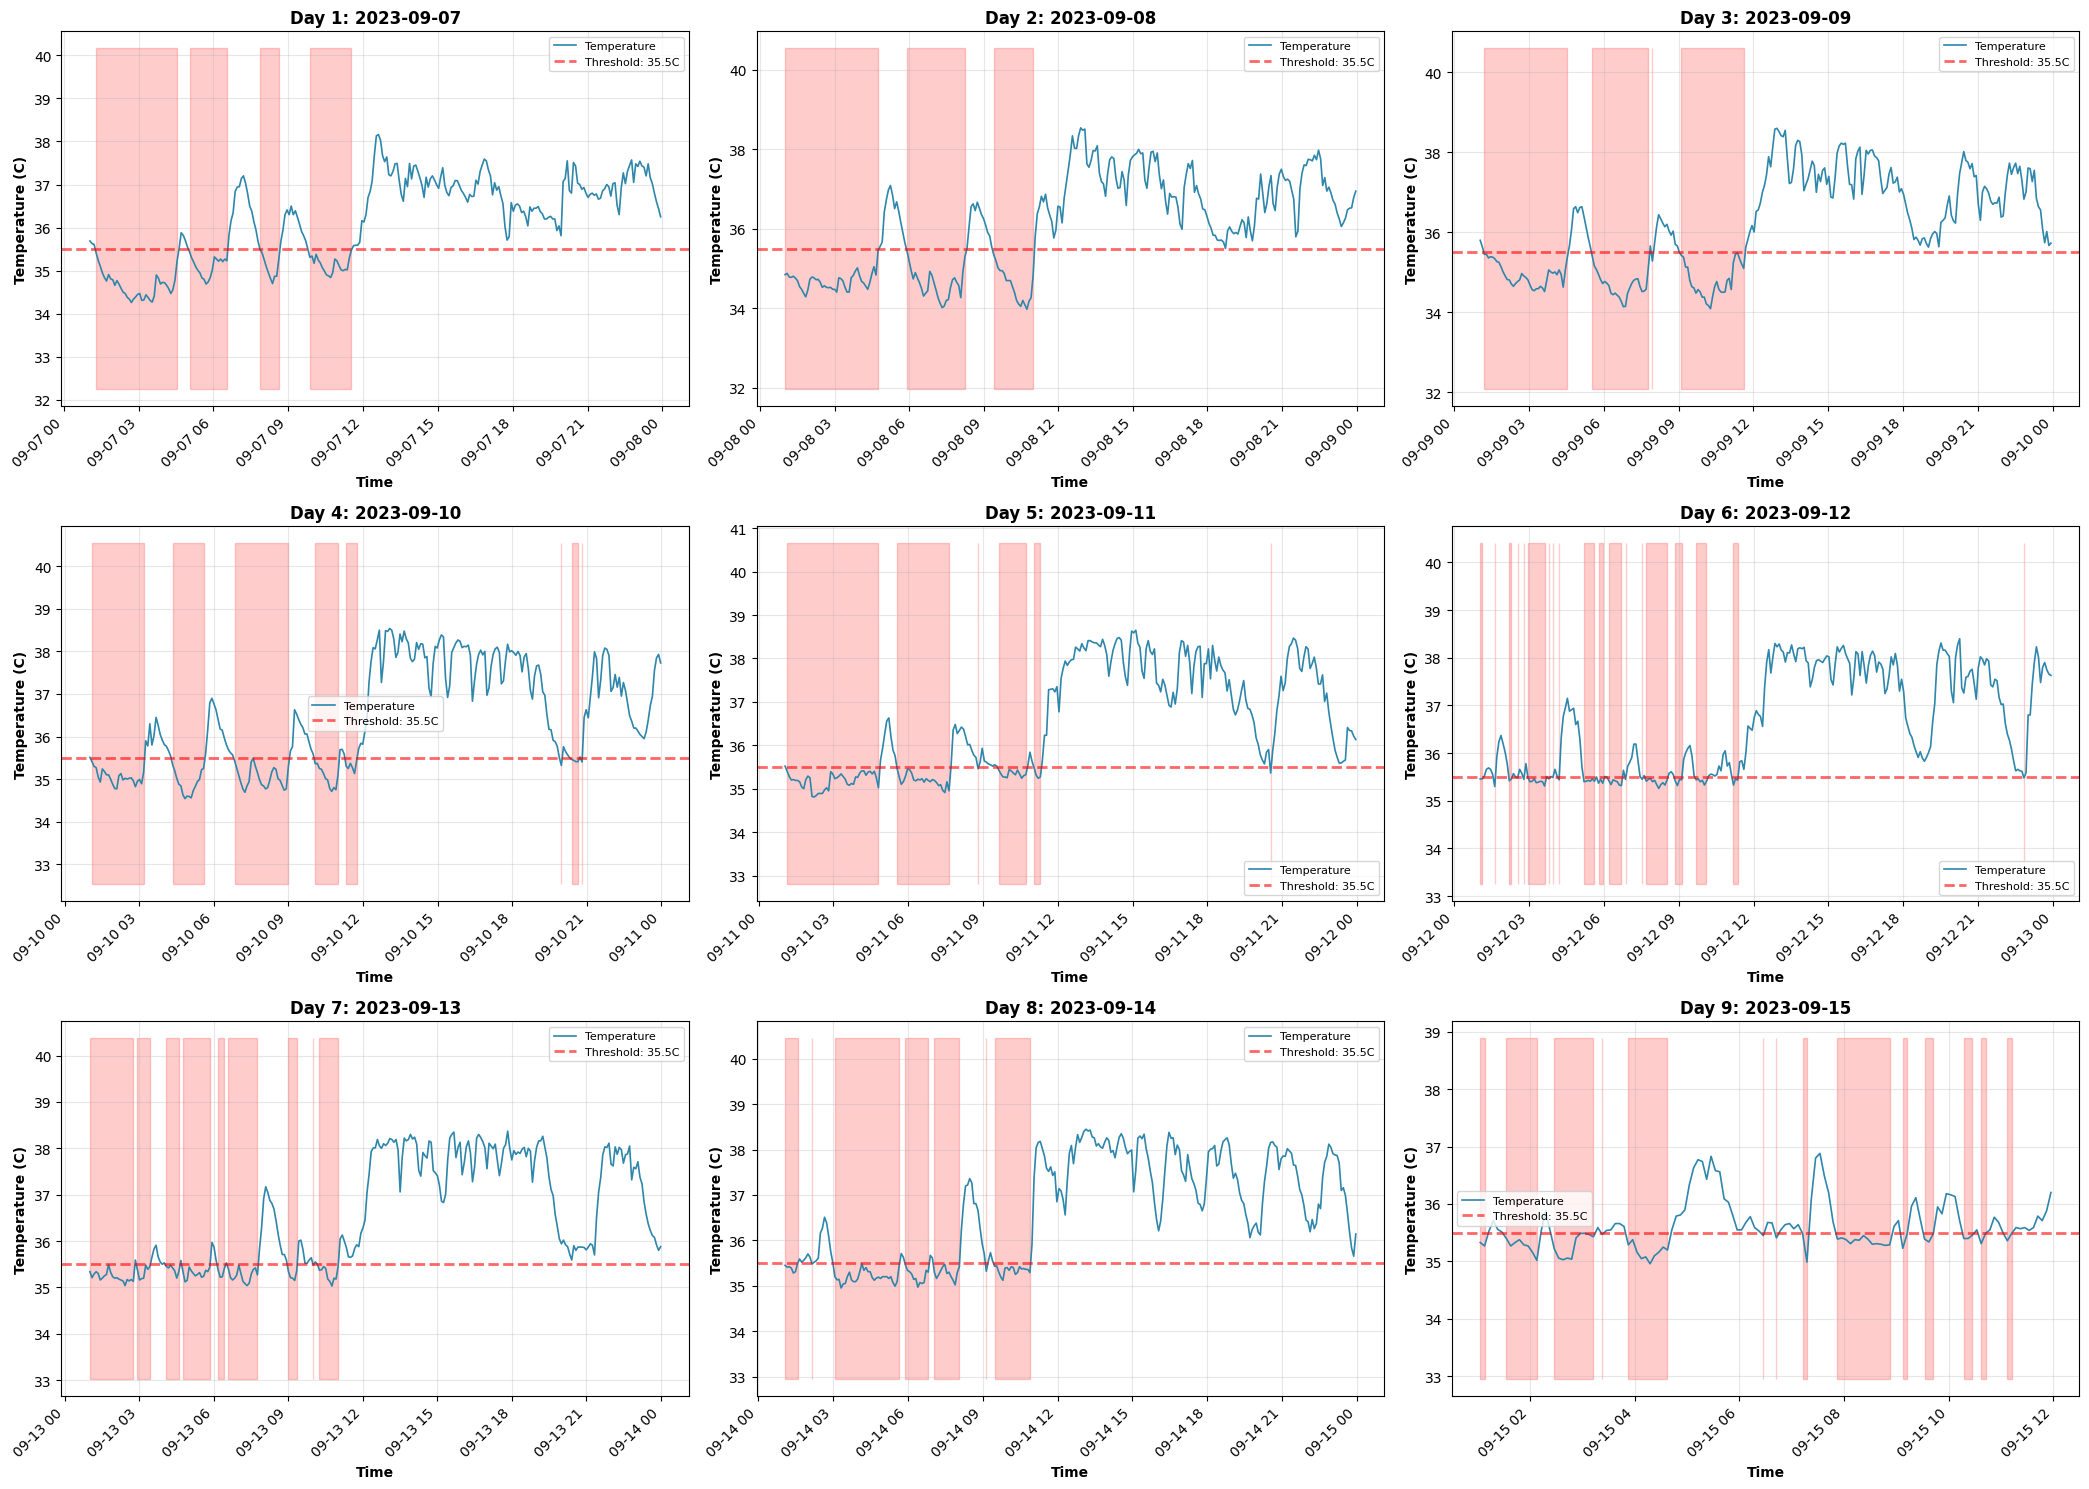


Torpor summary saved to 'torpor_summary_2023-09-07_onwards.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


To plot specific days:
  PLOT_MODE = 'individual'
  DAYS_TO_PLOT = [1, 2, 3]  # from 1-9


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# ============== CONFIGURATION ==============
FOOD_REMOVAL_DATE = '2023-09-05'
SKIP_FIRST_N_DAYS = 2
SKIP_FIRST_HOUR_EACH_DAY = True

# Very forgiving parameters to catch all potential torpor
TORPOR_THRESHOLD = 35.5  # Based on 25th percentile
MIN_TORPOR_DURATION = 0.25  # Only 15 minutes minimum

PLOT_MODE = 'summary'  # 'summary', 'individual', or 'calibration'
DAYS_TO_PLOT = [1, 2, 3, 4, 5]
# ==========================================

from google.colab import files
print("Please upload your Excel file...")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("\n" + "="*80)
print(f"Processing: {filename}")
print("="*80 + "\n")

# Read Excel file
df = pd.read_excel(filename)
time_col = df.columns[0]
temp_col = df.columns[1]

df_clean = pd.DataFrame({
    'DateTime': pd.to_datetime(df[time_col], format='%d/%m/%Y %H:%M:%S', errors='coerce'),
    'Temperature': df[temp_col]
})
df_clean = df_clean.dropna()

print("FULL DATASET:")
print(f"  Date range: {df_clean['DateTime'].min().date()} to {df_clean['DateTime'].max().date()}")
print(f"  Total days: {(df_clean['DateTime'].max() - df_clean['DateTime'].min()).days + 1}")
print(f"  Total readings: {len(df_clean):,}")

# Filter to post-food-removal data
start_datetime = pd.to_datetime(FOOD_REMOVAL_DATE) + timedelta(days=SKIP_FIRST_N_DAYS)
post_removal_df = df_clean[df_clean['DateTime'] >= start_datetime].copy()

print(f"\nANALYSIS PERIOD:")
print(f"  Food removed: {FOOD_REMOVAL_DATE}")
print(f"  Skipping first {SKIP_FIRST_N_DAYS} days after food removal")
print(f"  Analysis starts: {start_datetime.date()}")
print(f"  Date range: {post_removal_df['DateTime'].min().date()} to {post_removal_df['DateTime'].max().date()}")
print(f"  Days analyzed: {(post_removal_df['DateTime'].max() - post_removal_df['DateTime'].min()).days + 1}")

# Remove first hour of each day
if SKIP_FIRST_HOUR_EACH_DAY:
    post_removal_df['hour_of_day'] = post_removal_df['DateTime'].dt.hour + post_removal_df['DateTime'].dt.minute / 60
    initial_count = len(post_removal_df)
    post_removal_df = post_removal_df[post_removal_df['hour_of_day'] >= 1.0].copy()
    removed_count = initial_count - len(post_removal_df)
    print(f"  Removed first hour of each day: {removed_count:,} readings (calibration period)")

print(f"  Final readings: {len(post_removal_df):,}")

# Temperature statistics
print(f"\nTEMPERATURE STATISTICS:")
print("="*80)
temp_stats = post_removal_df['Temperature'].describe(percentiles=[.05, .10, .25, .50, .75, .90, .95])
for stat, value in temp_stats.items():
    print(f"  {stat:8s}: {value:6.2f}C")

print(f"\n  Coldest 5% of readings: < {temp_stats['5%']:.2f}C")
print(f"  Coldest 10% of readings: < {temp_stats['10%']:.2f}C")
print(f"  Coldest 25% of readings: < {temp_stats['25%']:.2f}C")
print("="*80 + "\n")

# Torpor detection
print(f"TORPOR DETECTION:")
print(f"  Threshold: {TORPOR_THRESHOLD}C")
print(f"  Minimum duration: {MIN_TORPOR_DURATION} hours")
print("="*80 + "\n")

# Mark torpor periods
post_removal_df['is_torpor'] = post_removal_df['Temperature'] < TORPOR_THRESHOLD
below_threshold_count = post_removal_df['is_torpor'].sum()
below_threshold_pct = (below_threshold_count / len(post_removal_df)) * 100

print(f"  Readings below {TORPOR_THRESHOLD}C: {below_threshold_count:,} ({below_threshold_pct:.1f}%)")

if below_threshold_count == 0:
    print(f"\n  No readings below {TORPOR_THRESHOLD}C found!")
    print(f"  Suggested thresholds:")
    print(f"    - {temp_stats['10%']:.1f}C (coldest 10%)")
    print(f"    - {temp_stats['25%']:.1f}C (coldest 25%)")
    print(f"    - {temp_stats['50%']:.1f}C (median)")
else:
    post_removal_df['bout_change'] = post_removal_df['is_torpor'] != post_removal_df['is_torpor'].shift()
    post_removal_df['bout_id'] = post_removal_df['bout_change'].cumsum()

    # Analyze bouts
    all_bouts = post_removal_df[post_removal_df['is_torpor']].groupby('bout_id').agg({
        'DateTime': ['first', 'last', 'count'],
        'Temperature': ['min', 'mean']
    })

    print(f"  Temperature drops below threshold: {len(all_bouts)}")

    # Filter by duration
    valid_bouts = []

    for idx, row in all_bouts.iterrows():
        start = row[('DateTime', 'first')]
        end = row[('DateTime', 'last')]
        duration_hours = (end - start).total_seconds() / 3600

        if duration_hours >= MIN_TORPOR_DURATION:
            valid_bouts.append({
                'bout_id': idx,
                'start': start,
                'end': end,
                'duration_hours': duration_hours,
                'min_temp': row[('Temperature', 'min')],
                'mean_temp': row[('Temperature', 'mean')],
                'date': start.date()
            })

    if len(valid_bouts) == 0:
        print(f"\n  No torpor bouts lasting >= {MIN_TORPOR_DURATION} hours found!")
        print(f"\n  All detected temperature drops:")
        for idx, row in all_bouts.iterrows():
            start = row[('DateTime', 'first')]
            end = row[('DateTime', 'last')]
            duration_hours = (end - start).total_seconds() / 3600
            min_temp = row[('Temperature', 'min')]
            print(f"    {start} -> {end}")
            print(f"    Duration: {duration_hours:.2f}h | Min: {min_temp:.2f}C")
    else:
        print(f"  Valid torpor bouts found: {len(valid_bouts)}\n")

        # Group by date
        torpor_days = {}
        for bout in valid_bouts:
            date = bout['date']
            if date not in torpor_days:
                torpor_days[date] = []
            torpor_days[date].append(bout)

        print(f"DAYS WITH TORPOR ({len(torpor_days)} days):")
        print("="*80)

        torpor_day_list = []
        total_torpor_hours_all = 0

        for day_num, (date, bouts) in enumerate(sorted(torpor_days.items()), 1):
            print(f"\nDay {day_num}: {date} ({len(bouts)} bout(s))")
            torpor_day_list.append(date)

            day_torpor_time = 0
            for bout_num, bout in enumerate(bouts, 1):
                day_torpor_time += bout['duration_hours']
                print(f"  Bout {bout_num}: {bout['start'].strftime('%H:%M:%S')} -> {bout['end'].strftime('%H:%M:%S')}")
                print(f"          Duration: {bout['duration_hours']:.2f}h | Min: {bout['min_temp']:.2f}C | Mean: {bout['mean_temp']:.2f}C")

            total_torpor_hours_all += day_torpor_time
            print(f"  Daily total: {day_torpor_time:.2f} hours in torpor")

        print(f"\n" + "="*80)
        print(f"SUMMARY:")
        print(f"  Total torpor days: {len(torpor_days)}")
        print(f"  Total torpor bouts: {len(valid_bouts)}")
        print(f"  Total time in torpor: {total_torpor_hours_all:.2f} hours")
        print(f"  Average bout duration: {total_torpor_hours_all/len(valid_bouts):.2f} hours")
        print("="*80 + "\n")

        # PLOTTING
        if PLOT_MODE == 'calibration':
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))

            # Temperature histogram
            ax1 = axes[0, 0]
            ax1.hist(post_removal_df['Temperature'], bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
            ax1.axvline(x=TORPOR_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {TORPOR_THRESHOLD}C')
            ax1.axvline(x=temp_stats['10%'], color='orange', linestyle=':', linewidth=2, label=f'10th percentile: {temp_stats["10%"]:.1f}C')
            ax1.axvline(x=temp_stats['25%'], color='green', linestyle=':', linewidth=2, label=f'25th percentile: {temp_stats["25%"]:.1f}C')
            ax1.set_xlabel('Temperature (C)', fontsize=11, fontweight='bold')
            ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax1.set_title('Temperature Distribution', fontsize=12, fontweight='bold')
            ax1.legend()
            ax1.grid(True, alpha=0.3, axis='y')

            # Time series
            ax2 = axes[0, 1]
            sample_data = post_removal_df.iloc[::10]
            ax2.plot(sample_data['DateTime'], sample_data['Temperature'], linewidth=0.5, color='#2E86AB', alpha=0.7)
            ax2.axhline(y=TORPOR_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {TORPOR_THRESHOLD}C')
            ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Temperature (C)', fontsize=11, fontweight='bold')
            ax2.set_title('Temperature Time Series', fontsize=12, fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

            # Daily min/max
            ax3 = axes[1, 0]
            daily_stats = post_removal_df.groupby(post_removal_df['DateTime'].dt.date)['Temperature'].agg(['min', 'max', 'mean'])
            ax3.plot(daily_stats.index, daily_stats['min'], 'o-', label='Daily Min', linewidth=2, markersize=5)
            ax3.plot(daily_stats.index, daily_stats['mean'], 's-', label='Daily Mean', linewidth=2, markersize=5)
            ax3.plot(daily_stats.index, daily_stats['max'], '^-', label='Daily Max', linewidth=2, markersize=5)
            ax3.axhline(y=TORPOR_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {TORPOR_THRESHOLD}C')
            ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
            ax3.set_ylabel('Temperature (C)', fontsize=11, fontweight='bold')
            ax3.set_title('Daily Temperature Range', fontsize=12, fontweight='bold')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

            # Hourly pattern
            ax4 = axes[1, 1]
            hourly_stats = post_removal_df.groupby(post_removal_df['DateTime'].dt.hour)['Temperature'].agg(['mean', 'min', 'max'])
            ax4.fill_between(hourly_stats.index, hourly_stats['min'], hourly_stats['max'], alpha=0.3, color='#2E86AB', label='Range')
            ax4.plot(hourly_stats.index, hourly_stats['mean'], 'o-', linewidth=2, color='#2E86AB', label='Mean')
            ax4.axhline(y=TORPOR_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold: {TORPOR_THRESHOLD}C')
            ax4.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Temperature (C)', fontsize=11, fontweight='bold')
            ax4.set_title('Temperature by Hour', fontsize=12, fontweight='bold')
            ax4.set_xlim(0, 23)
            ax4.set_xticks(range(0, 24, 3))
            ax4.legend()
            ax4.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        elif PLOT_MODE == 'summary':
            # Plot all torpor days in grid
            n_days = len(torpor_day_list)
            n_cols = min(3, n_days)
            n_rows = (n_days + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
            if n_days == 1:
                axes = np.array([axes])
            axes = axes.flatten() if n_days > 1 else axes

            for idx, date in enumerate(torpor_day_list):
                ax = axes[idx] if n_days > 1 else axes

                # Get data for this day
                day_start = pd.to_datetime(date)
                day_end = day_start + timedelta(days=1)
                day_data = post_removal_df[(post_removal_df['DateTime'] >= day_start) &
                                           (post_removal_df['DateTime'] < day_end)]

                # Plot temperature
                ax.plot(day_data['DateTime'], day_data['Temperature'], linewidth=1.2, color='#2E86AB', label='Temperature')

                # Mark threshold
                ax.axhline(y=TORPOR_THRESHOLD, color='red', linestyle='--', alpha=0.6, linewidth=2, label=f'Threshold: {TORPOR_THRESHOLD}C')

                # Highlight torpor periods
                torpor_mask = day_data['Temperature'] < TORPOR_THRESHOLD
                ax.fill_between(day_data['DateTime'], day_data['Temperature'].min() - 2, day_data['Temperature'].max() + 2,
                               where=torpor_mask, alpha=0.2, color='red')

                ax.set_xlabel('Time', fontsize=10, fontweight='bold')
                ax.set_ylabel('Temperature (C)', fontsize=10, fontweight='bold')
                ax.set_title(f'Day {idx+1}: {date}', fontsize=12, fontweight='bold')
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=8)
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

            # Hide unused subplots
            for idx in range(n_days, len(axes)):
                axes[idx].set_visible(False)

            plt.tight_layout()
            plt.show()

        elif PLOT_MODE == 'individual':
            # Plot specific days in detail
            for day_num in DAYS_TO_PLOT:
                if day_num > len(torpor_day_list):
                    print(f"WARNING: Day {day_num} requested but only {len(torpor_day_list)} torpor days found")
                    continue

                date = torpor_day_list[day_num - 1]
                day_start = pd.to_datetime(date)
                day_end = day_start + timedelta(days=1)
                day_data = post_removal_df[(post_removal_df['DateTime'] >= day_start) &
                                           (post_removal_df['DateTime'] < day_end)].copy()

                # Create detailed plot
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

                # Temperature plot
                ax1.plot(day_data['DateTime'], day_data['Temperature'], linewidth=1.2, color='#2E86AB', label='Body Temperature')
                ax1.axhline(y=TORPOR_THRESHOLD, color='red', linestyle='--', alpha=0.6, linewidth=2, label=f'Threshold: {TORPOR_THRESHOLD}C')

                torpor_mask = day_data['Temperature'] < TORPOR_THRESHOLD
                ax1.fill_between(day_data['DateTime'], day_data['Temperature'].min() - 2, day_data['Temperature'].max() + 2,
                                where=torpor_mask, alpha=0.2, color='red', label='Torpor period')

                ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
                ax1.set_ylabel('Temperature (C)', fontsize=12, fontweight='bold')
                ax1.set_title(f'Torpor Day {day_num}: {date}', fontsize=14, fontweight='bold')
                ax1.grid(True, alpha=0.3)
                ax1.legend(loc='best')
                plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

                # Rate of change
                day_data['temp_diff'] = day_data['Temperature'].diff()
                day_data['time_diff'] = day_data['DateTime'].diff().dt.total_seconds() / 60
                day_data['temp_rate'] = day_data['temp_diff'] / day_data['time_diff']

                ax2.plot(day_data['DateTime'], day_data['temp_rate'], linewidth=1, color='#A23B72', alpha=0.7)
                ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
                ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
                ax2.set_ylabel('dT/dt (C/min)', fontsize=12, fontweight='bold')
                ax2.set_title('Temperature Rate of Change', fontsize=13, fontweight='bold')
                ax2.grid(True, alpha=0.3)
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

                plt.tight_layout()
                plt.show()

        # Save summary
        summary_filename = f'torpor_summary_{start_datetime.date()}_onwards.csv'
        summary_data = []
        for day_num, date in enumerate(torpor_day_list, 1):
            for bout in torpor_days[date]:
                summary_data.append({
                    'Day': day_num,
                    'Date': date,
                    'Start_Time': bout['start'],
                    'End_Time': bout['end'],
                    'Duration_Hours': bout['duration_hours'],
                    'Min_Temp': bout['min_temp'],
                    'Mean_Temp': bout['mean_temp']
                })

        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(summary_filename, index=False)
        print(f"\nTorpor summary saved to '{summary_filename}'")
        files.download(summary_filename)

        print(f"\n" + "="*80)
        print("To plot specific days:")
        print("  PLOT_MODE = 'individual'")
        print(f"  DAYS_TO_PLOT = [1, 2, 3]  # from 1-{len(torpor_day_list)}")
        print("="*80)